# Features for Microglia in P6 mouse Cortex

In [1]:
!pip install scProject -U
import random
random.seed(a=613)
import numpy as np
import scProject
import scanpy as sc
patterns = sc.read_h5ad('patterns_anndata.h5ad')
dataset = sc.read_h5ad('test_target.h5ad')
dataset_filtered, patterns_filtered = scProject.matcher.filterAnnDatas(dataset, patterns, 'gene_id')



  Attempting uninstall: scProject
    Found existing installation: scProject 1.0.9.82
    Uninstalling scProject-1.0.9.82:
      Successfully uninstalled scProject-1.0.9.82
(55371, 428) dataset filter shape
(80, 428) patterns filter shape


Trying to set attribute `.X` of view, copying.
Trying to set attribute `.X` of view, copying.


Low regularization low 1% lasso

(55371, 80)
[DARPP-32 cells, Excitatory Neurons, Astrocyte/Radial Glia, Oligodendrocyte, Vascular Endothelium, ..., Cycling Neural Progenitor, Brain Fibroblasts, Unknown, Microglia, Vascular Smooth Muscle]
Length: 12
Categories (12, object): [DARPP-32 cells, Excitatory Neurons, Astrocyte/Radial Glia, Oligodendrocyte, ..., Brain Fibroblasts, Unknown, Microglia, Vascular Smooth Muscle]


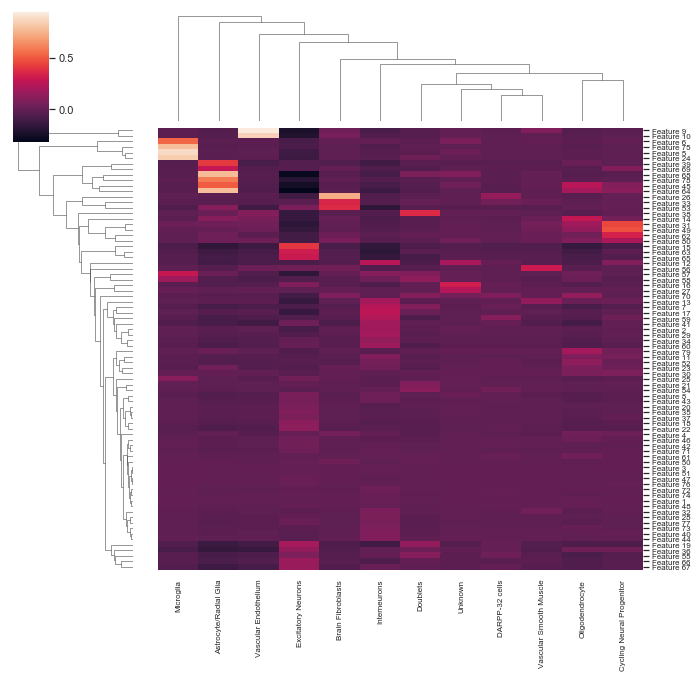

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']= [10, 12]
scProject.rg.NNLR_ElasticNet(dataset_filtered, patterns_filtered, 'MG01', .0001, .01)
scProject.viz.pearsonMatrix(dataset_filtered, patterns_filtered, 'CellType', 12, 'MG01', 'MG01Pears', True)

[DARPP-32 cells, Excitatory Neurons, Astrocyte/Radial Glia, Oligodendrocyte, Vascular Endothelium, ..., Cycling Neural Progenitor, Brain Fibroblasts, Unknown, Microglia, Vascular Smooth Muscle]
Length: 12
Categories (12, object): [DARPP-32 cells, Excitatory Neurons, Astrocyte/Radial Glia, Oligodendrocyte, ..., Brain Fibroblasts, Unknown, Microglia, Vascular Smooth Muscle]


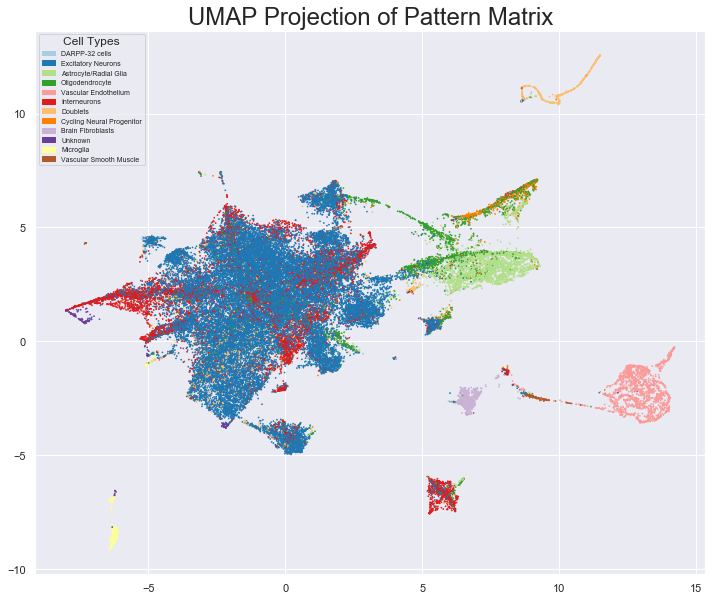

In [3]:
plt.rcParams['figure.figsize']= [12, 10]
scProject.viz.UMAP_Projection(dataset_filtered, 'CellType', 'MG01', 'UMAPMG01', 20)

Number of nonzero cells 1911


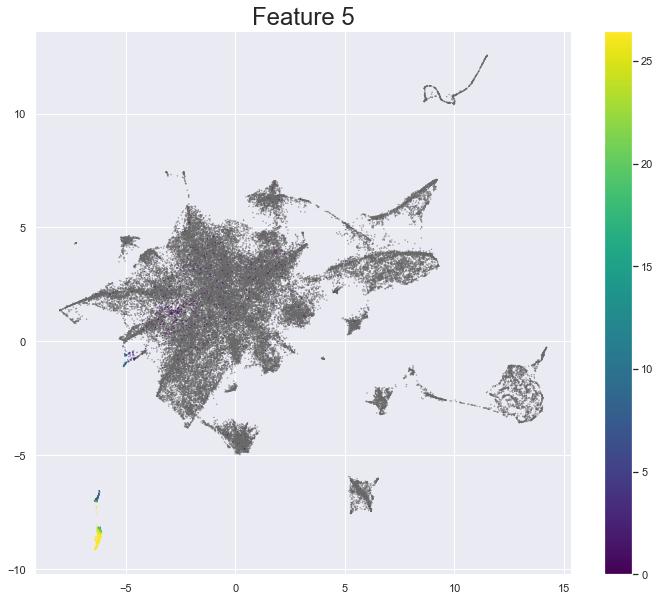

Number of nonzero cells 5739


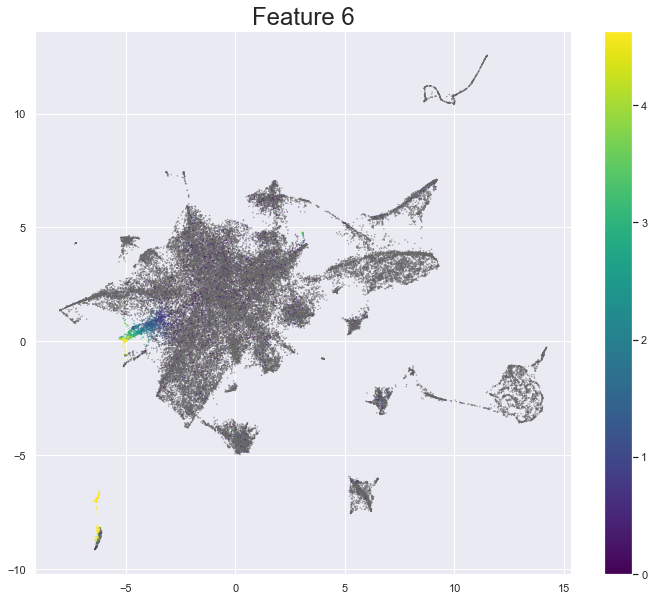

Number of nonzero cells 4252


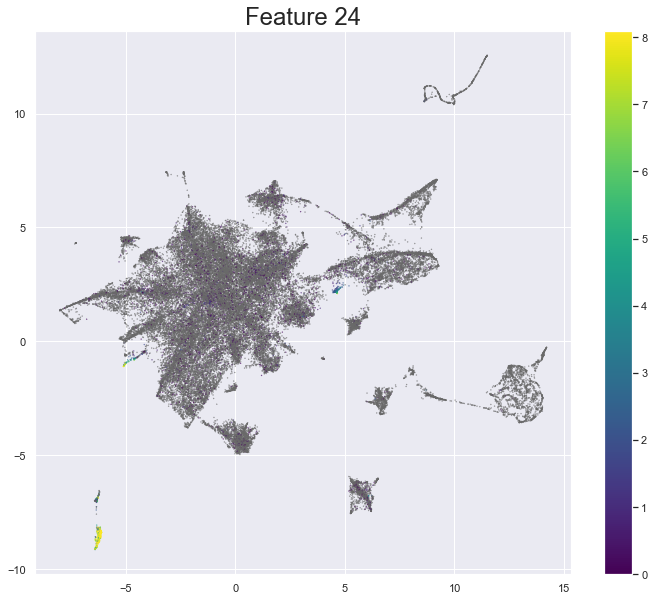

Number of nonzero cells 7121


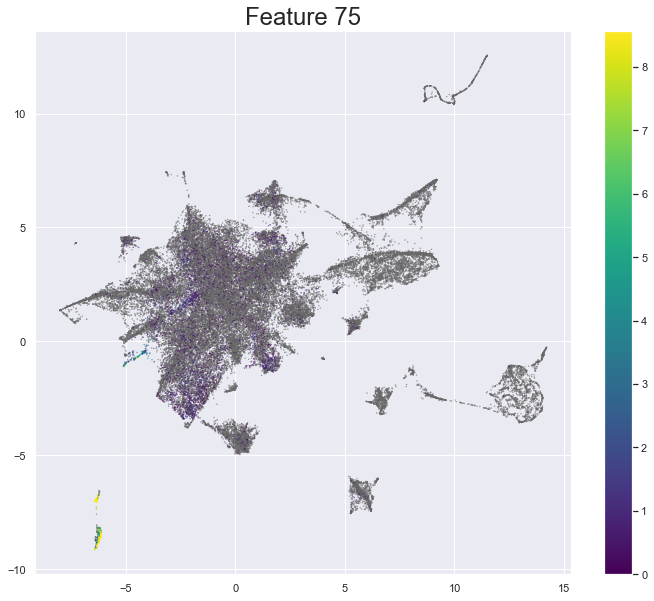

In [4]:
scProject.viz.featurePlots(dataset_filtered, [5, 6, 24, 75], 'MG01', 'UMAPMG01')

As expected from the Pearson plot, features 5 and 24 are the stronger markers of microglia in the P6 mouse cortex. Lets up the lasso to encourage sparsity and strengthen the features that are the real drivers.

(55371, 80)
[DARPP-32 cells, Excitatory Neurons, Astrocyte/Radial Glia, Oligodendrocyte, Vascular Endothelium, ..., Cycling Neural Progenitor, Brain Fibroblasts, Unknown, Microglia, Vascular Smooth Muscle]
Length: 12
Categories (12, object): [DARPP-32 cells, Excitatory Neurons, Astrocyte/Radial Glia, Oligodendrocyte, ..., Brain Fibroblasts, Unknown, Microglia, Vascular Smooth Muscle]


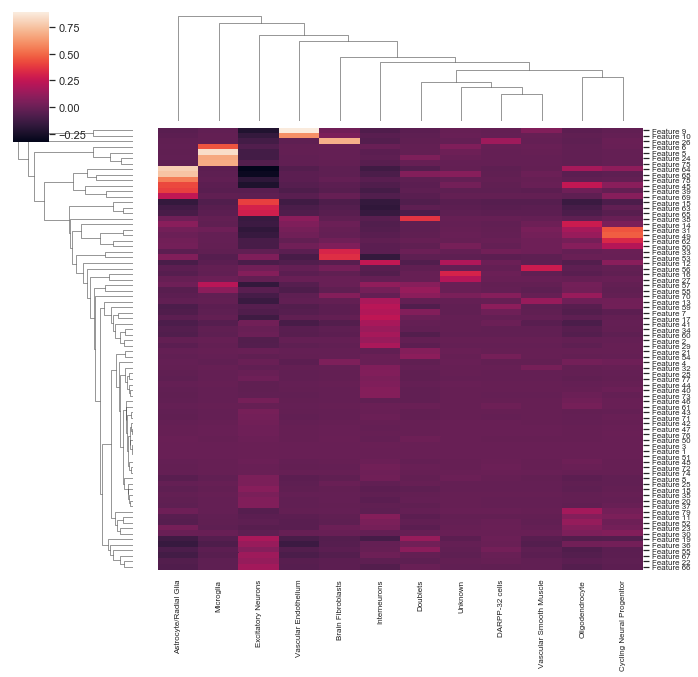

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']= [10, 12]
scProject.rg.NNLR_ElasticNet(dataset_filtered, patterns_filtered, 'MG99', .0001, .99)
scProject.viz.pearsonMatrix(dataset_filtered, patterns_filtered, 'CellType', 12, 'MG99', 'MG99Pears', True)

[DARPP-32 cells, Excitatory Neurons, Astrocyte/Radial Glia, Oligodendrocyte, Vascular Endothelium, ..., Cycling Neural Progenitor, Brain Fibroblasts, Unknown, Microglia, Vascular Smooth Muscle]
Length: 12
Categories (12, object): [DARPP-32 cells, Excitatory Neurons, Astrocyte/Radial Glia, Oligodendrocyte, ..., Brain Fibroblasts, Unknown, Microglia, Vascular Smooth Muscle]


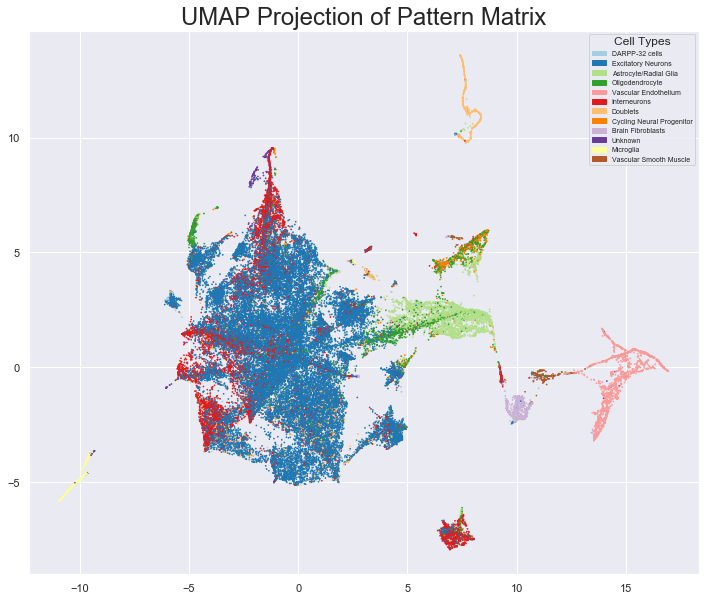

In [6]:
plt.rcParams['figure.figsize']= [12, 10]
scProject.viz.UMAP_Projection(dataset_filtered, 'CellType', 'MG99', 'UMAPMG99', 20)

One nice feature of scProject is that you can use the UMAP coordinates generated from a previous regression. This can be useful when you increase the regularization and the UMAPs become harder to decipher. These are the feature plots, but on the original UMAP coordinates.

Number of nonzero cells 1266


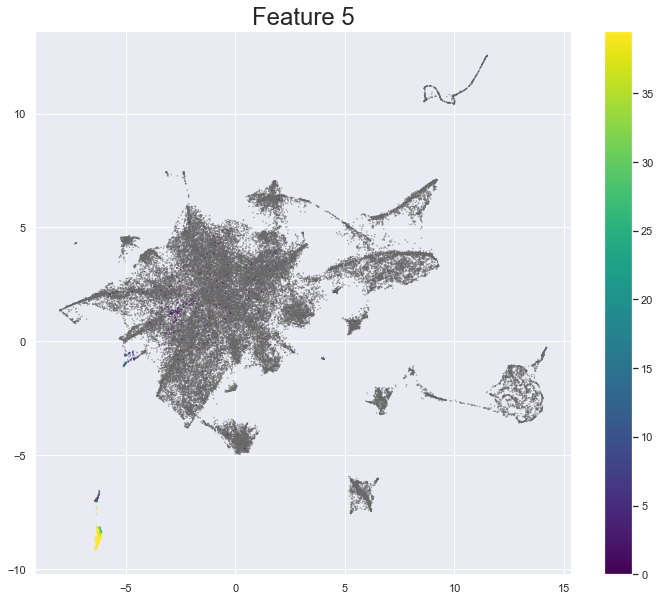

Number of nonzero cells 4407


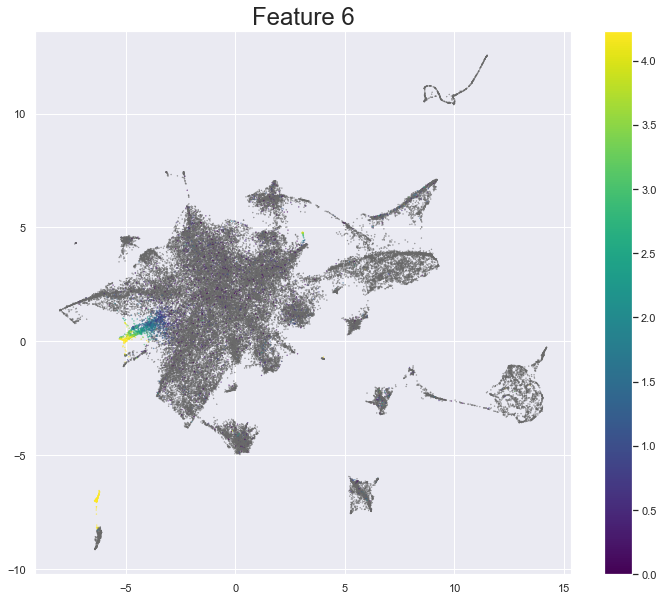

Number of nonzero cells 3656


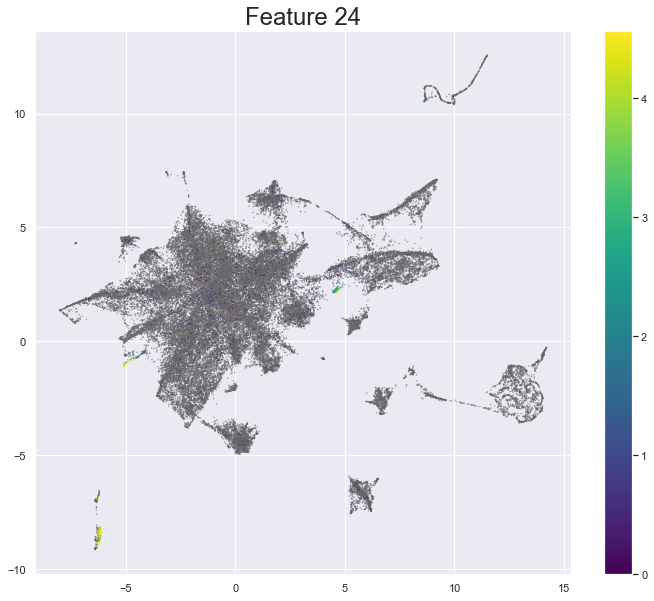

Number of nonzero cells 5132


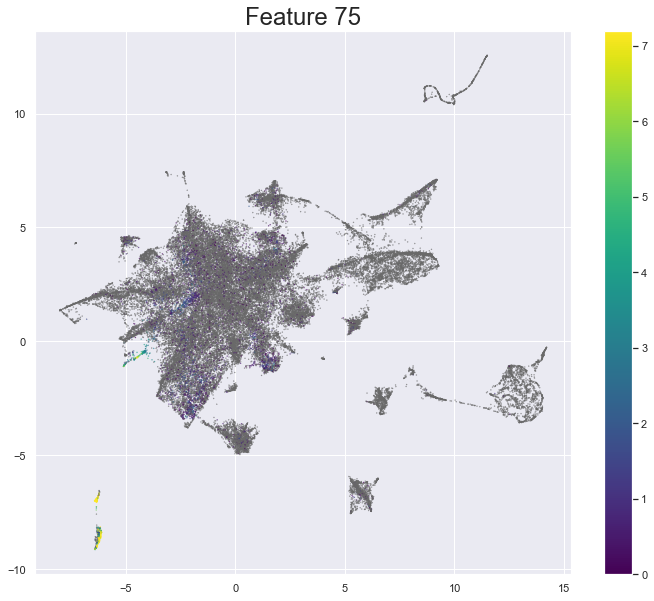

In [7]:
scProject.viz.featurePlots(dataset_filtered, [5, 6, 24, 75], 'MG99', 'UMAPMG01')

This is the typical feature weights on a newly generated UMAP coordinate system.

(582, 80)
Number of nonzero cells 506


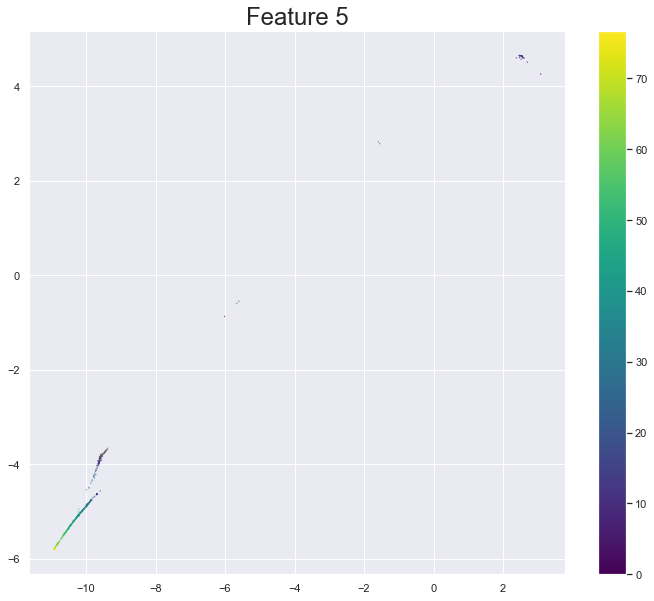

Number of nonzero cells 167


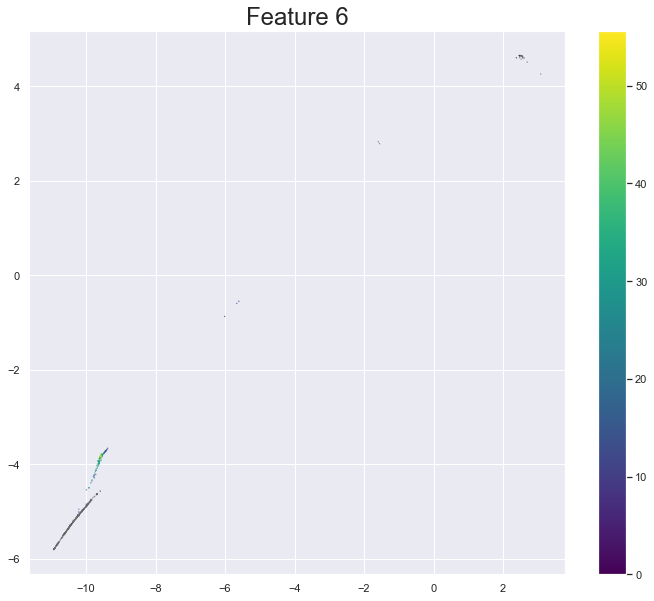

Number of nonzero cells 434


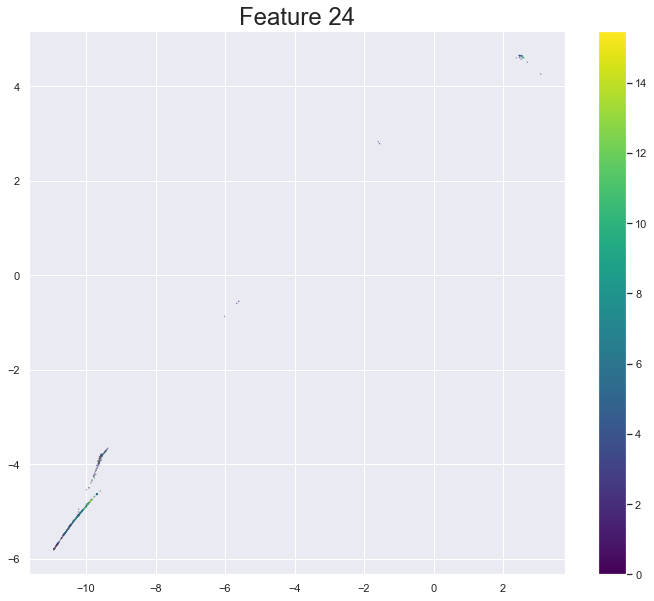

Number of nonzero cells 505


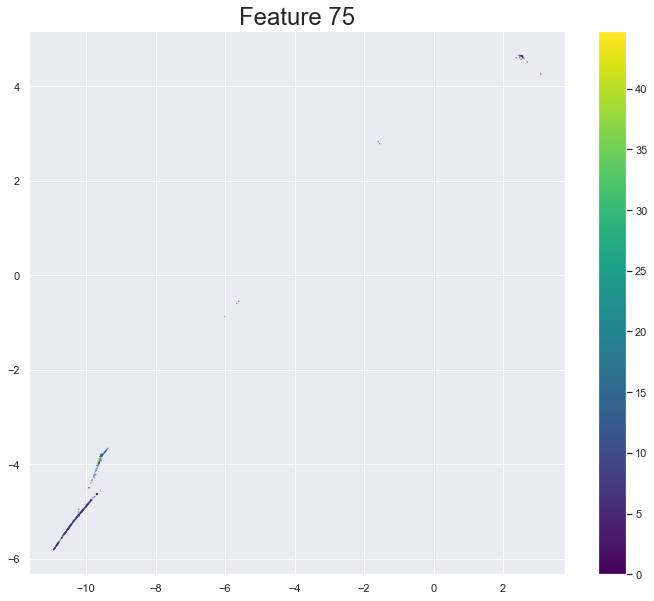

In [8]:
scProject.viz.featurePlots(dataset_filtered, [5, 6, 24, 75], 'MG99', 'UMAPMG99', subset=['Microglia'], obsColumn='CellType')

While this is clearly over regularized some features 5, 6 and 75(because of how many nonzero cells) persist. Lets print out the highest expressed genes from the features of interest and see what's inside.

In [9]:
print(scProject.stats.importantGenes(patterns_filtered, 5, .05), "Feature 5 Genes")
print(scProject.stats.importantGenes(patterns_filtered, 6, .05), "Feature 6 Genes")
print(scProject.stats.importantGenes(patterns_filtered, 24, .1), "Feature 24 Genes")
print(scProject.stats.importantGenes(patterns_filtered, 75, .1), "Feature 75 Genes")

[Index(['ENSMUSG00000026358', 'ENSMUSG00000058715', 'ENSMUSG00000060802',
       'ENSMUSG00000027199', 'ENSMUSG00000027447', 'ENSMUSG00000017707',
       'ENSMUSG00000025283', 'ENSMUSG00000049775', 'ENSMUSG00000038642',
       'ENSMUSG00000028581', 'ENSMUSG00000000682', 'ENSMUSG00000036905',
       'ENSMUSG00000036896', 'ENSMUSG00000029484', 'ENSMUSG00000029580',
       'ENSMUSG00000030220', 'ENSMUSG00000002985', 'ENSMUSG00000030579',
       'ENSMUSG00000030560', 'ENSMUSG00000007891', 'ENSMUSG00000041515',
       'ENSMUSG00000021876', 'ENSMUSG00000021939', 'ENSMUSG00000040204',
       'ENSMUSG00000052336', 'ENSMUSG00000000982', 'ENSMUSG00000018930',
       'ENSMUSG00000005583', 'ENSMUSG00000021665', 'ENSMUSG00000001175',
       'ENSMUSG00000021190', 'ENSMUSG00000033220', 'ENSMUSG00000068220',
       'ENSMUSG00000024397', 'ENSMUSG00000079419', 'ENSMUSG00000024677'],
      dtype='object', name='index')] Feature 5 Genes
[Index(['ENSMUSG00000026126', 'ENSMUSG00000059498', 'ENSMUSG000000587

In short, Feature 24 which is expressed in a fraction of microglia has high expression of C1qa, C1qb, C1qc genes. Feature 24 is not included in all of the microglia suggesting that there exists a subtype of microglia in the P6 mouse cortex that expresses C1qa through c in much higher amounts. Features 5, 6, and 75 do not have the C1qs expressed in their most important genes. This shows a subtyping of microglia in terms of expression of C1q expression.

To better understand the expression of C1q a-c, lets use gene selectivity to understand what the model is doing.

Feature 5 expresses 11.083000153303146% of gene ENSMUSG00000036887
Feature 6 expresses 7.832718640565872% of gene ENSMUSG00000036887
Feature 24 expresses 44.47410702705383% of gene ENSMUSG00000036887


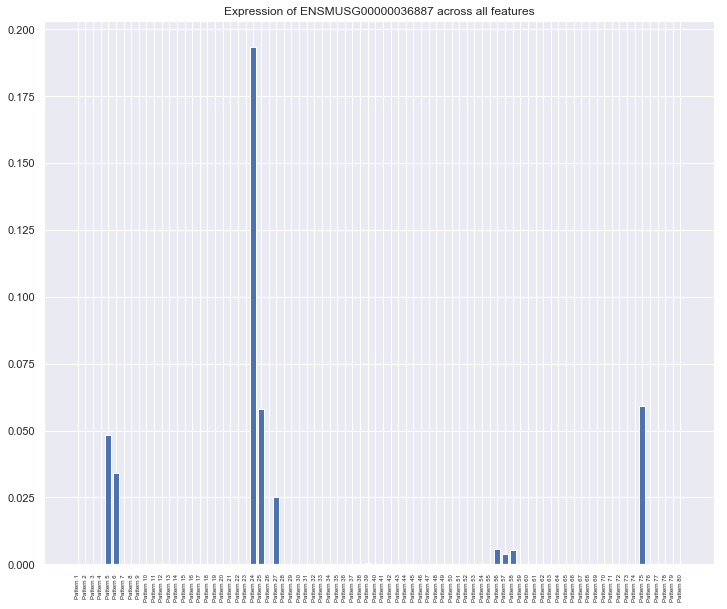

Feature 5 expresses 12.099885195493698% of gene ENSMUSG00000036905
Feature 6 expresses 11.364411562681198% of gene ENSMUSG00000036905
Feature 24 expresses 35.02193987369537% of gene ENSMUSG00000036905


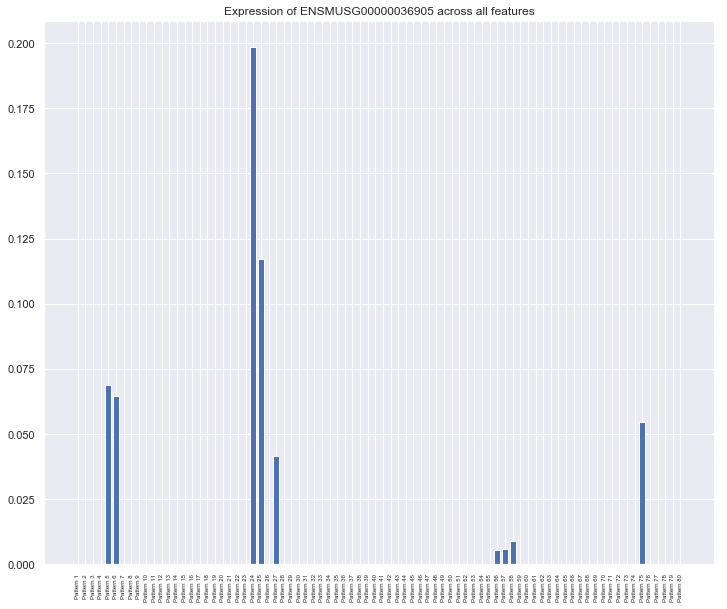

Feature 5 expresses 12.562157213687897% of gene ENSMUSG00000036896
Feature 6 expresses 8.364727348089218% of gene ENSMUSG00000036896
Feature 24 expresses 37.7030223608017% of gene ENSMUSG00000036896


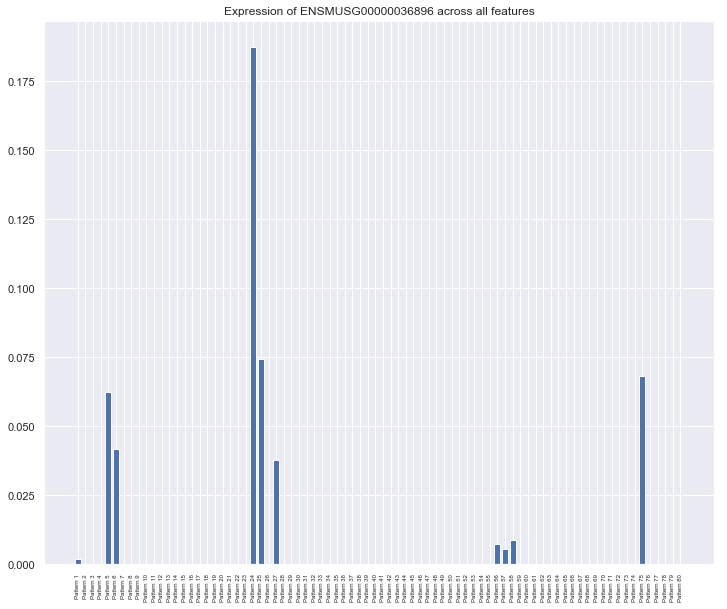

(582, 80)


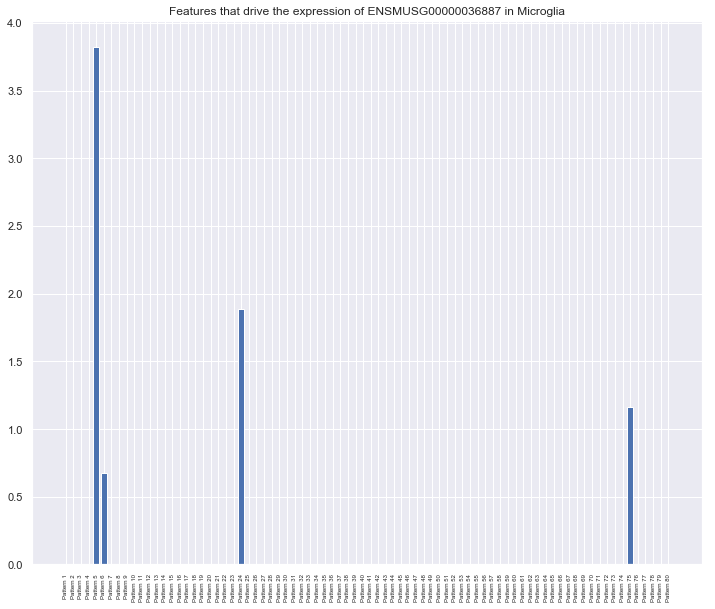

(582, 80)


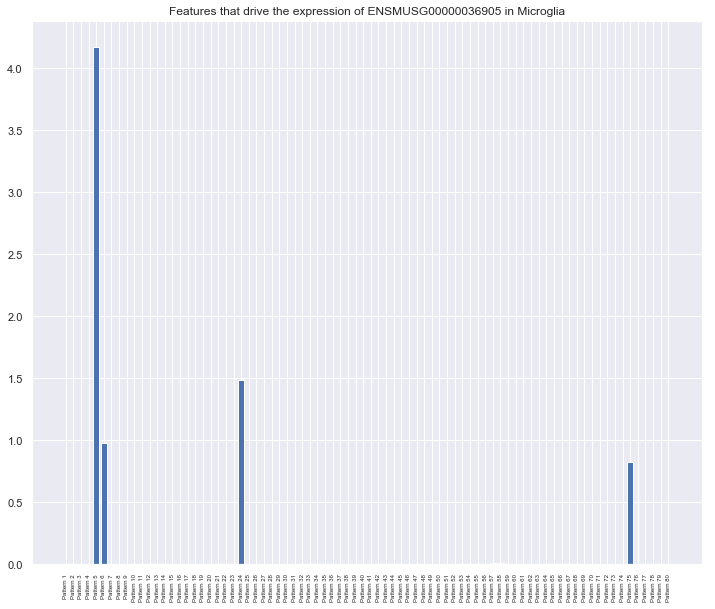

(582, 80)


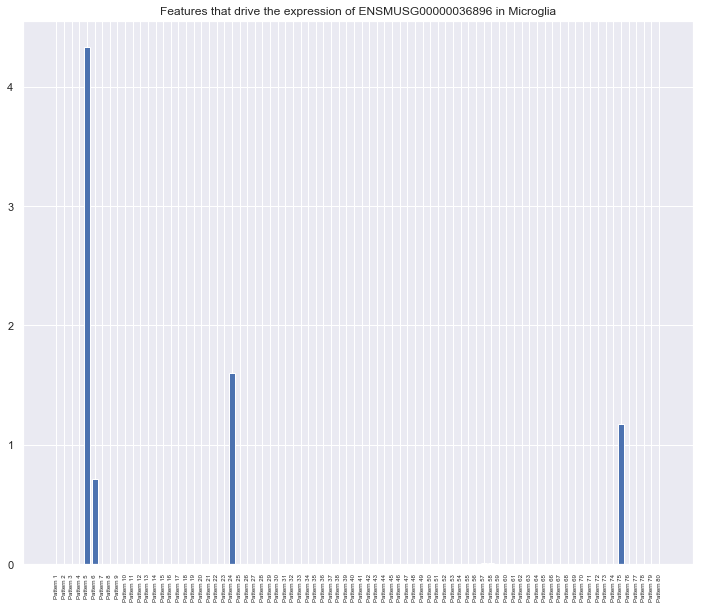

In [10]:
scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000036887', 5, False) #C1qa
scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000036887', 6, False) #C1qa
scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000036887', 24, True) #C1qa

scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000036905', 5, False) #C1qb
scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000036905', 6, False) #C1qb
scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000036905', 24, True) #C1qb

scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000036896', 5, False) #C1qc
scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000036896', 6, False) #C1qc
scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000036896', 24, True) #C1qc

scProject.stats.geneDriver(dataset_filtered, patterns_filtered, 'ENSMUSG00000036887', 'CellType',
                                       "Microglia", "MG99")
scProject.stats.geneDriver(dataset_filtered, patterns_filtered, 'ENSMUSG00000036905', 'CellType',
                                       "Microglia", "MG99")
scProject.stats.geneDriver(dataset_filtered, patterns_filtered, 'ENSMUSG00000036896', 'CellType',
                                       "Microglia", "MG99")

Feature 24 expresses 11.780047416687012% of gene ENSMUSG00000059498


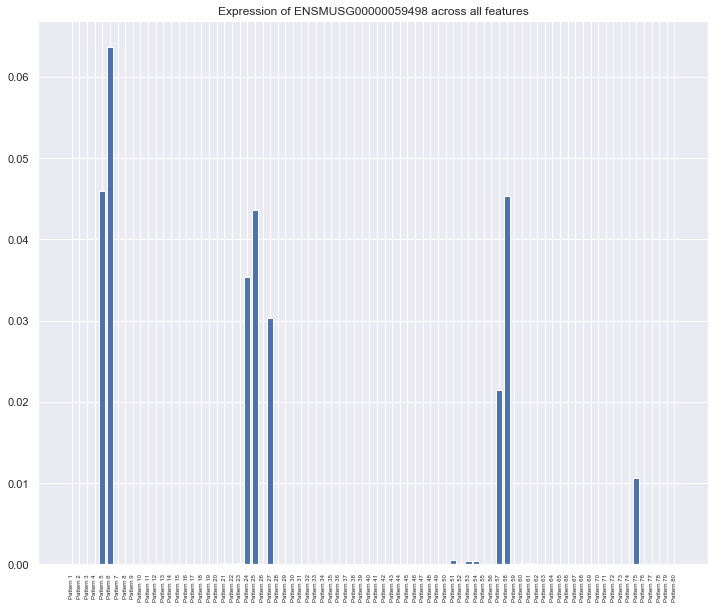

In [11]:
scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000059498', 24, True)

The model chose the best features to use in the samples. As we saw in the previous plots, feature 5 is the largest driver of microglia. It is important to note that these plots take the average of all of the cells annotated as microglia, but from the feature plots we know that some microglia express more of feature 6 and others more feature 24. The first plots clearly show that feature 24 expresses much more of all three genes. Next, we show the utility of the stats in scProject to see which genes are driving the difference between subtypes. Below, I split the microglia into two groups based on their expression of feature 6.

In [12]:
microglia= dataset_filtered[dataset_filtered.obs['CellType'].isin(['Microglia'])]
print(microglia.shape)
C1 = microglia[microglia.obsm['MG01'][:, 5] > 0]
C2 = microglia[microglia.obsm['MG01'][:, 5] == 0]
print(C1.X.shape)
print(C2.X.shape)

(582, 428)
(338, 428)
(244, 428)


First, we need to check whether the expression of feature 5 is significant. scProject's featureExpressionSig allows us to test the null hypothesis that the mean expression/use of feature 5 in cluster 1 is 0 using a simple t-test. The method returns the t-value at the specified level of confidence and the t-value from the data.

In [13]:
scProject.stats.featureExpressionSig(C1, 'MG01', 6, .999999)

We can reject the null hypothesis that the mean is 0.


(ArrayView(20.91454177), 4.8379134541378335)

Since, difference in feature expression does not guarantee (formally) difference in gene expression. We use scProject's HotellingT2 to test the null hypothesis that the mean gene expression of cluster1 and cluster2 are the same.

In [14]:
scProject.stats.HotellingT2(C1, C2)

T2 Value: 4464.677440968222 FValue: 2.751754948711481 P-Value: 2.261302256556519e-12


(ArrayView([[4464.67744097]]),
 ArrayView([[2.75175495]]),
 array([[2.26130226e-12]]))

Lastly, to find the genes driving/causing the difference in gene expression. scProject uses Bonferroni confidence intervals on the difference of the means to see which genes can be used to discriminate between the clusters.

In [15]:
l =scProject.stats.BonferroniCorrectedDifferenceMeans(C1, C2, .99999, 'gene_short_name')

Gene Name: Ptpn18 Mean Difference: 2.140714645385742 Low: 0.7200574710923491 High 3.5613718196791355
Gene Name: Slc40a1 Mean Difference: 1.5469820499420166 Low: 0.342251293596187 High 2.751712806287846
Gene Name: Fcer1g Mean Difference: 1.6743741035461426 Low: 0.3351266755790383 High 3.013621531513247
Gene Name: Mrc1 Mean Difference: 7.50319766998291 Low: 4.321900570277625 High 10.684494769688195
Gene Name: Ehd4 Mean Difference: 2.343035936355591 Low: 0.48481351431556696 High 4.201258358395615
Gene Name: Cst3 Mean Difference: -0.7813588380813599 Low: -1.0747229726215533 High -0.4879947035411664
Gene Name: Gpr34 Mean Difference: -5.992095947265625 Low: -8.363319430740392 High -3.620872463790859
Gene Name: P2ry12 Mean Difference: -6.276315689086914 Low: -8.566015690920356 High -3.9866156872534715
Gene Name: S100a1 Mean Difference: 0.41294747591018677 Low: 0.045648874404893736 High 0.7802460774154798
Gene Name: Ctss Mean Difference: -2.2079343795776367 Low: -4.309204329499611 High -0.1066